In [1]:
install.packages("kknn")
install.packages("GGally")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

 Predicting The Occurrence of Exercised Induced-Angina by Analysis of Blood Pressure and Maximum Heart Rate

Introduction: 

Background Information: 


Methods & Results: 

In [3]:
url<- "https://raw.githubusercontent.com/elaines6/dsci-100-group-project/main/processed.cleveland.data"
heart_raw_data <- read_csv(url, col_names = c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_bs", "rest_ecg", "max_rate",
                                             "exercise_induced_angina", "ST_depression", "slope_peak_exercise", "major_vessels", "thal", "diagnosis_heart_disease"))
heart_data_tidy <- heart_raw_data |>
    mutate(sex = as_factor(sex), chest_pain_type = as_factor(chest_pain_type), exercise_induced_angina = as_factor(exercise_induced_angina)) |>
    mutate(sex = fct_recode(sex, "Female" = "0", "Male" = "1")) |>
    mutate(exercise_induced_angina = fct_recode(exercise_induced_angina, "Yes" = "1", "No" = "0")) |>
    mutate(chest_pain_type = fct_recode(chest_pain_type, "Typical angina" = "1", "Atypical angina" = "2", "Non-anginal pain" = "3", "Asymptomatic" = "4")) |>
    filter(age != "?" & sex != "?"& chest_pain_type != "?"& resting_bp != "?"& max_rate!= "?"& exercise_induced_angina != "?")

unscaled_heart_data <- heart_data_tidy |>
    select(resting_bp, max_rate, exercise_induced_angina) |>
    mutate(resting_bp = as.integer(resting_bp), max_rate = as.integer(max_rate))


#Checking the stnadardized data matter
unscaled_heart_data_to_check<- heart_data_tidy|>
    select(resting_bp, age, exercise_induced_angina)|>
    mutate(resting_bp= as.integer(resting_bp), max_rate = as.integer(age))

#After deciding the which plot to use, we decided to use heart_plot_four which is age and max_rate
final_unsclaed_heart_data<- heart_data_tidy|>
    select(age, max_rate, exercise_induced_angina)|>
    mutate(age = as.integer(age), max_rate = as.integer(max_rate))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): major_vessels, thal
dbl (12): age, sex, chest_pain_type, resting_bp, chol, fasting_bs, rest_ecg,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
heart_raw_data[heart_raw_data == "?"] <- NA

heart_raw_data %>%
    map_df(~sum(is.na(.x)))

age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,4,2,0


In [5]:
heart_data_tidy

age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,Male,Typical angina,145,233,1,2,150,No,2.3,3,0.0,6.0,0
67,Male,Asymptomatic,160,286,0,2,108,Yes,1.5,2,3.0,3.0,2
67,Male,Asymptomatic,120,229,0,2,129,Yes,2.6,2,2.0,7.0,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,Male,Asymptomatic,130,131,0,0,115,Yes,1.2,2,1.0,7.0,3
57,Female,Atypical angina,130,236,0,2,174,No,0.0,2,1.0,3.0,1
38,Male,Non-anginal pain,138,175,0,0,173,No,0.0,1,?,3.0,0


From this cell to plot below is for checking whether the standardized data matters for deciding the best predictors

In [6]:
heart_recipe<- recipe(exercise_induced_angina ~ ., data = unscaled_heart_data_to_check)
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

In [7]:
heart_recipe <- heart_recipe |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) |>
  prep()
heart_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 303 data points and no missing data.

Operations:

Scaling for resting_bp, age, max_rate [trained]
Centering for resting_bp, age, max_rate [trained]

In [8]:
scaled_heart_rate <- bake(heart_recipe, unscaled_heart_data_to_check)
scaled_heart_rate

resting_bp,age,max_rate,exercise_induced_angina
<dbl>,<dbl>,<dbl>,<fct>
0.7562740,0.9471596,0.9471596,No
1.6085589,1.3897030,1.3897030,Yes
-0.6642009,1.3897030,1.3897030,Yes
⋮,⋮,⋮,⋮
-0.09601098,0.2833446,0.2833446,Yes
-0.09601098,0.2833446,0.2833446,No
0.35854099,-1.8187363,-1.8187363,No


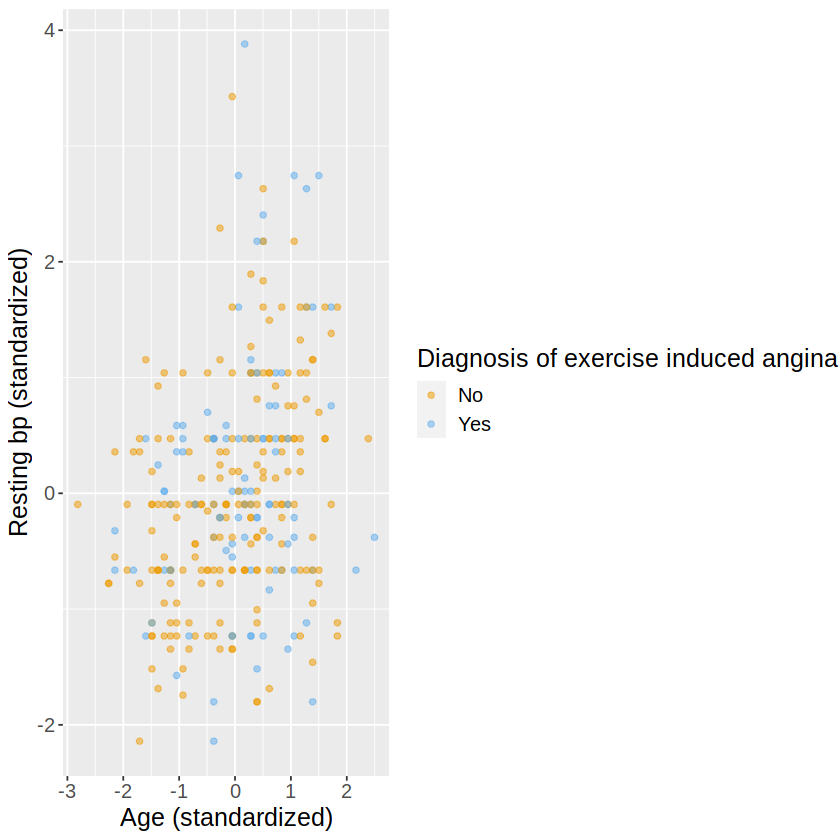

In [9]:
heart_plot_testing <- scaled_heart_rate|>
    ggplot(aes(x= age, y= resting_bp, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Age (standardized)", 
         y= "Resting bp (standardized)",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_testing

In [10]:
#Getting the number of samples in the plot 4, but do I need to upsample this??
final_unsclaed_heart_data|>
    group_by(exercise_induced_angina)|>
    summarize(count= n())

exercise_induced_angina,count
<fct>,<int>
No,204
Yes,99


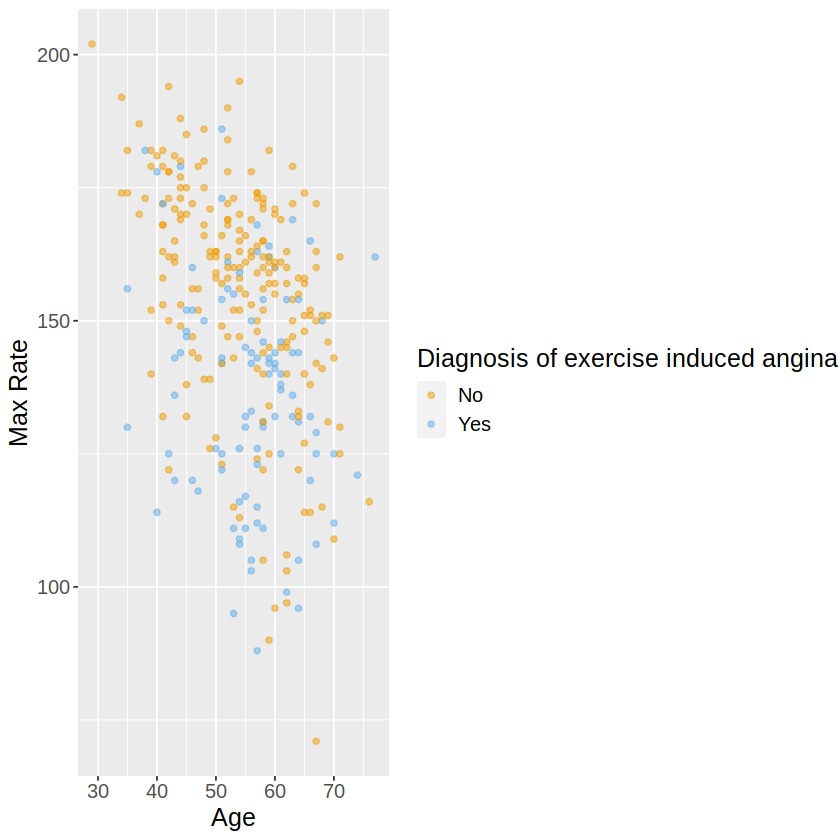

In [11]:
heart_plot_four <- heart_data_tidy|>
    ggplot(aes(x= age, y= max_rate, color = exercise_induced_angina))+ 
    geom_point(alpha= 0.5) +
    labs(x= "Age", 
         y= "Max Rate",
         color = "Diagnosis of exercise induced angina") +
    scale_color_manual(values = c("orange2", "steelblue2")) + 
    theme(text = element_text(size = 15))

heart_plot_four

In [12]:
#Getting the average values of the each columns. This means that I cannot get the average of everything. 
predictors_of_heart_data<- heart_data_tidy
mean_of_columns<- colMeans(predictors_of_heart_data) 
mean_of_columns

frame_of_mean <- tibble( row.names=c("age", "sex", "chest_pain_type", "resting_bp", "chol", "fasting_bs", "rest_ecg", "max_rate",
                                             "exercise_induced_angina", "ST_depression", "slope_peak_exercise", "major_vessels", "thal", "diagnosis_heart_disease"), mean_of_columns)
frame_of_mean


ERROR: Error in colMeans(predictors_of_heart_data): 'x' must be numeric


In [13]:
#Getting K value which has the highgest accuracy
heart_split<- initial_split(heart_data_tidy, prop= 0.75, strata= exercise_induced_angina)
heart_train<- training(heart_split)
heart_test<- testing(heart_split) 

In [14]:
glimpse(heart_train)

Rows: 227
Columns: 14
$ age                     <dbl> 63, 41, 56, 62, 63, 57, 56, 52, 48, 49, 58, 58…
$ sex                     <fct> Male, Female, Male, Female, Male, Male, Female…
$ chest_pain_type         <fct> Typical angina, Atypical angina, Atypical angi…
$ resting_bp              <dbl> 145, 130, 120, 140, 130, 140, 140, 172, 130, 1…
$ chol                    <dbl> 233, 204, 236, 268, 254, 192, 294, 199, 275, 2…
$ fasting_bs              <dbl> 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0…
$ rest_ecg                <dbl> 2, 2, 0, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 0, 0…
$ max_rate                <dbl> 150, 172, 178, 160, 147, 148, 153, 162, 139, 1…
$ exercise_induced_angina <fct> No, No, No, No, No, No, No, No, No, No, No, No…
$ ST_depression           <dbl> 2.3, 1.4, 0.8, 3.6, 1.4, 0.4, 1.3, 0.5, 0.2, 0…
$ slope_peak_exercise     <dbl> 3, 1, 1, 3, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 3, 1…
$ major_vessels           <chr> "0.0", "0.0", "0.0", "2.0", "1.0", "0.0", "0.0…
$ thal            

In [15]:
glimpse(heart_test)

Rows: 76
Columns: 14
$ age                     <dbl> 67, 37, 44, 57, 48, 54, 64, 58, 60, 55, 58, 51…
$ sex                     <fct> Male, Male, Male, Male, Male, Male, Male, Fema…
$ chest_pain_type         <fct> Asymptomatic, Non-anginal pain, Atypical angin…
$ resting_bp              <dbl> 120, 130, 120, 150, 110, 140, 110, 120, 117, 1…
$ chol                    <dbl> 229, 250, 263, 168, 229, 239, 211, 340, 230, 3…
$ fasting_bs              <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0…
$ rest_ecg                <dbl> 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2…
$ max_rate                <dbl> 129, 187, 173, 174, 168, 160, 144, 172, 160, 1…
$ exercise_induced_angina <fct> Yes, No, No, No, No, No, Yes, No, Yes, Yes, No…
$ ST_depression           <dbl> 2.6, 3.5, 0.0, 1.6, 1.0, 1.2, 1.8, 0.0, 1.4, 1…
$ slope_peak_exercise     <dbl> 2, 3, 1, 1, 3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1…
$ major_vessels           <chr> "2.0", "0.0", "0.0", "0.0", "0.0", "0.0", "0.0…
$ thal             

In [16]:
#Getting the proportion of the induced_angina in the 
heart_proportions <- heart_train |>
                      group_by(exercise_induced_angina) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(heart_train))

heart_proportions

exercise_induced_angina,n,percent
<fct>,<int>,<dbl>
No,153,67.40088
Yes,74,32.59912


In [17]:
heart_recipe <- recipe(exercise_induced_angina ~ age + max_rate, data = heart_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

In [18]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6078393,10,0.03105208,Preprocessor1_Model01
3,accuracy,binary,0.6737154,10,0.02521545,Preprocessor1_Model02
5,accuracy,binary,0.6911397,10,0.03016980,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
45,accuracy,binary,0.7229578,10,0.02564231,Preprocessor1_Model23
47,accuracy,binary,0.7138669,10,0.02356129,Preprocessor1_Model24
49,accuracy,binary,0.7184124,10,0.02427626,Preprocessor1_Model25


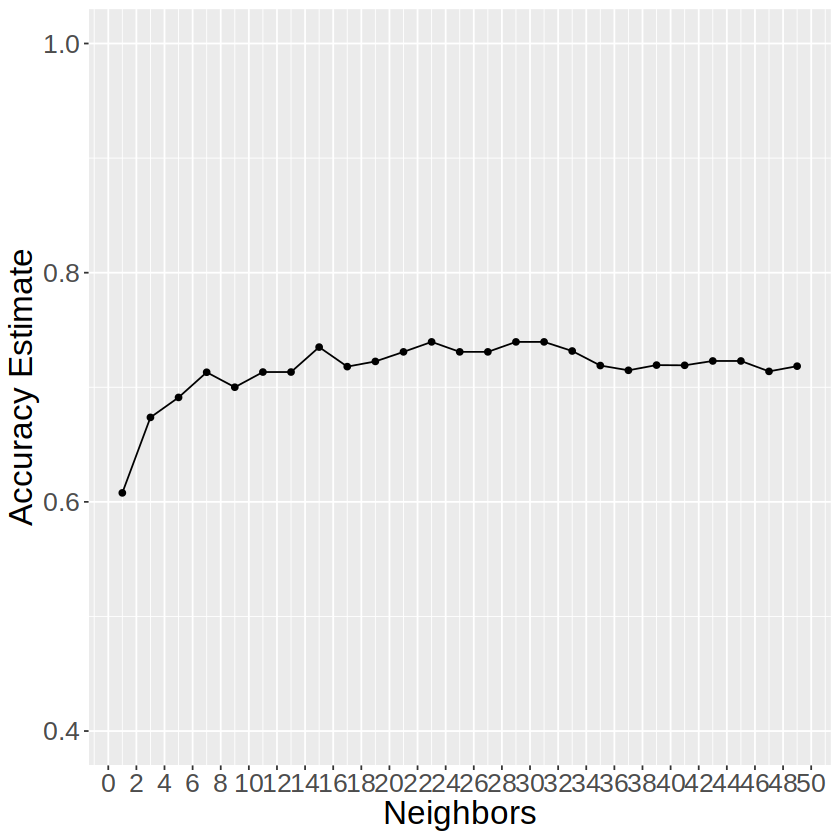

In [22]:
heart_vfold <- vfold_cv(heart_train, v = 10, strata = exercise_induced_angina)


k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

knn_results <- workflow() |>
  add_recipe(heart_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = heart_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                     geom_point() +
                     geom_line() +
                     labs(x = "Neighbors", y = "Accuracy Estimate") +
                     theme(text = element_text(size = 20)) +
                     scale_x_continuous(breaks = seq(0, 50, by = 2)) +
                     scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

In [23]:
final_heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 42) |>
       set_engine("kknn") |>
       set_mode("classification")

final_heart_fit <- workflow() |>
             add_recipe(heart_recipe) |>
             add_model(final_heart_spec) |>
            fit(data = heart_train)
final_heart_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(42,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2951542
Best kernel: rectangular
Best k: 42

In [28]:
heart_predictions <- predict(final_heart_fit, heart_test) |>
                        bind_cols(heart_test)

heart_predictions

heart_metrics <- heart_predictions |> metrics(truth = exercise_induced_angina, estimate = .pred_class)
heart_conf_mat <- heart_predictions |>
                        conf_mat(truth = exercise_induced_angina, estimate = .pred_class) 
heart_metrics
heart_conf_mat

.pred_class,age,sex,chest_pain_type,resting_bp,chol,fasting_bs,rest_ecg,max_rate,exercise_induced_angina,ST_depression,slope_peak_exercise,major_vessels,thal,diagnosis_heart_disease
<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
No,67,Male,Asymptomatic,120,229,0,2,129,Yes,2.6,2,2.0,7.0,1
No,37,Male,Non-anginal pain,130,250,0,0,187,No,3.5,3,0.0,3.0,0
No,44,Male,Atypical angina,120,263,0,0,173,No,0.0,1,0.0,7.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
No,44,Male,Asymptomatic,120,169,0,0,144,Yes,2.8,3,0.0,6.0,2
No,68,Male,Asymptomatic,144,193,1,0,141,No,3.4,2,2.0,7.0,2
Yes,57,Male,Asymptomatic,130,131,0,0,115,Yes,1.2,2,1.0,7.0,3


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7368421
kap,binary,0.3362445


          Truth
Prediction No Yes
       No  46  15
       Yes  5  10

In [ ]:
False negatvie top right and false positive left bottom and true negative left top  true negative false negative is more serious. 